In [1]:
import pandas as pd

# Load the provided files to understand their structure
customers_path = 'Customers.csv'
transactions_path = 'Transactions.csv'
products_path = 'Products.csv'

In [2]:
# Read the files
customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)
products_df = pd.read_csv(products_path)

In [3]:
# Display the first few rows of each file to understand their structure
customers_df.head(), transactions_df.head(), products_df.head()

(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  ,
   ProductID              ProductName     Catego

In [4]:
# Merge Transactions with Customers and Products data
merged_df = transactions_df.merge(customers_df, on='CustomerID', how='left')
merged_df = merged_df.merge(products_df, on='ProductID', how='left')

In [5]:
# Aggregate metrics for each customer
customer_metrics = merged_df.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),
    AverageTransactionValue=('TotalValue', 'mean'),
    PurchaseFrequency=('TransactionID', 'count'),
    AverageQuantity=('Quantity', 'mean')
).reset_index()


In [6]:
# Add region as a feature (encoding categorical data)
customer_regions = customers_df[['CustomerID', 'Region']]
customer_metrics = customer_metrics.merge(customer_regions, on='CustomerID', how='left')

In [7]:
# One-hot encode the 'Region' feature
customer_metrics = pd.get_dummies(customer_metrics, columns=['Region'], drop_first=True)

customer_metrics.head()

,CustomerID,TotalSpending,AverageTransactionValue,PurchaseFrequency,AverageQuantity,Region_Europe,Region_North America,Region_South America
0,C0001,3354.52,670.904,5,2.400000,False,False,True
1,C0002,1862.74,465.685,4,2.500000,False,False,False
2,C0003,2725.38,681.345,4,3.500000,False,False,True
3,C0004,5354.88,669.360,8,2.875000,False,False,True
4,C0005,2034.24,678.080,3,2.333333,False,False,False


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Drop the CustomerID for clustering purposes
clustering_data = customer_metrics.drop(columns=['CustomerID'])

In [9]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

In [10]:
# Evaluate clustering for different numbers of clusters (2 to 10)
db_scores = []
cluster_range = range(2, 11)
cluster_models = {}

In [11]:
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, cluster_labels)
    db_scores.append(db_index)
    cluster_models[k] = (kmeans, cluster_labels)

C:\Users\rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rohan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

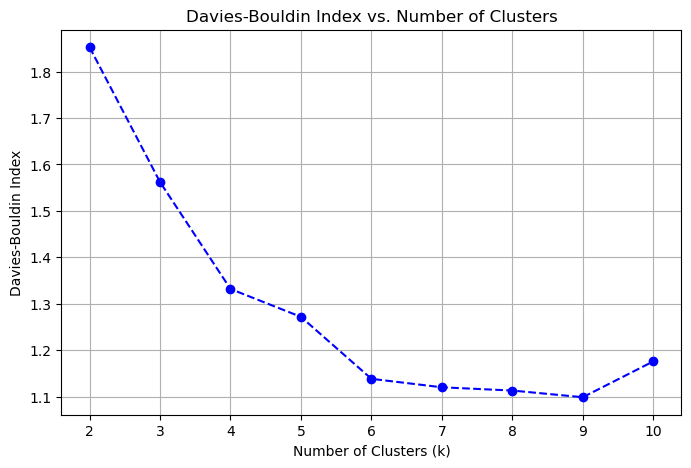

In [12]:
# Plot DB Index for different cluster sizes
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_scores, marker='o', linestyle='--', color='b')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [13]:
# Choose the optimal number of clusters with the lowest DB Index
optimal_k = cluster_range[db_scores.index(min(db_scores))]
optimal_k, min(db_scores)

(9, 1.098693825772817)

In [14]:
import seaborn as sns

# Assign cluster labels for the optimal model
optimal_kmeans, cluster_labels = cluster_models[optimal_k]
customer_metrics['Cluster'] = cluster_labels

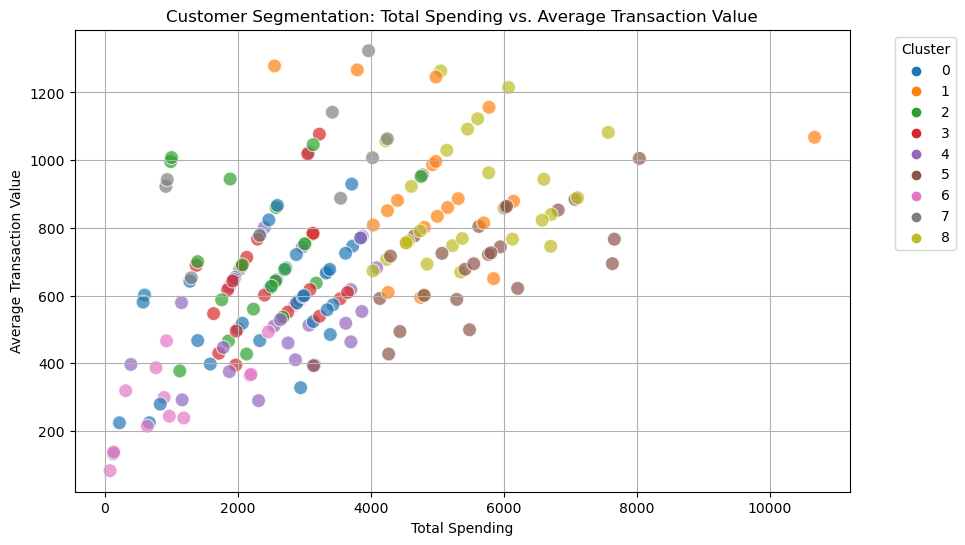

In [15]:
# Visualize clusters using TotalSpending and AverageTransactionValue
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_metrics['TotalSpending'],
    y=customer_metrics['AverageTransactionValue'],
    hue=customer_metrics['Cluster'],
    palette='tab10',
    s=100,
    alpha=0.7
)
plt.title('Customer Segmentation: Total Spending vs. Average Transaction Value')
plt.xlabel('Total Spending')
plt.ylabel('Average Transaction Value')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


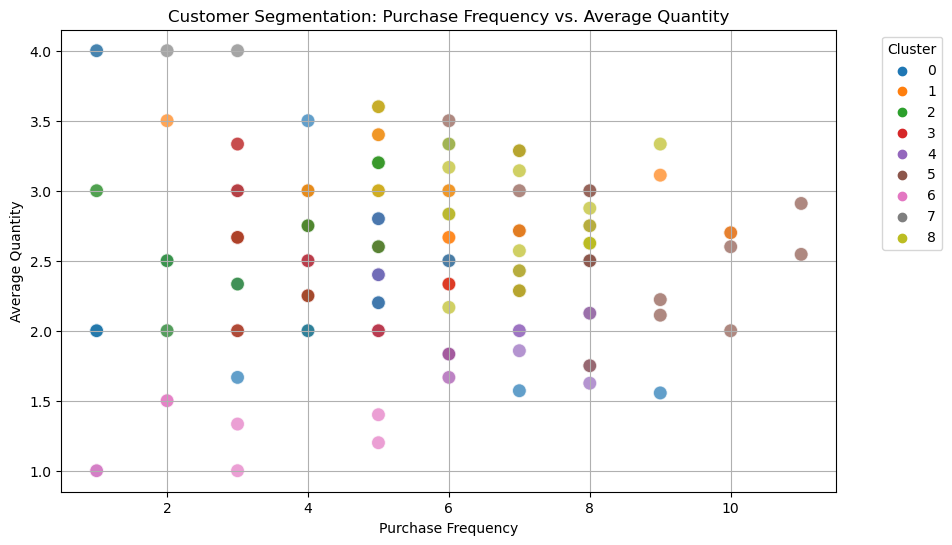

Cluster
0    33
4    29
8    26
5    24
2    23
3    21
1    20
6    12
7    11
Name: count, dtype: int64

In [16]:
# Visualize distribution of clusters for PurchaseFrequency and AverageQuantity
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_metrics['PurchaseFrequency'],
    y=customer_metrics['AverageQuantity'],
    hue=customer_metrics['Cluster'],
    palette='tab10',
    s=100,
    alpha=0.7
)
plt.title('Customer Segmentation: Purchase Frequency vs. Average Quantity')
plt.xlabel('Purchase Frequency')
plt.ylabel('Average Quantity')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Summary of cluster distribution
customer_metrics['Cluster'].value_counts()